In [1]:
%matplotlib inline
from fns import *
from syntheticdata import synthetic_generation

In [2]:
def create_conv_net(x, keep_prob, channels, n_class, layers=3, features_root=16, filter_size=3, pool_size=2, summaries=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,nz,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    :param summaries: Flag if summaries should be created
    """
    
    logging.info("Layers: {layers}, FeaturesRoot: {features_root}, ConvolutionSize: {filter_size}*{filter_size}*{filter_size}, PoolingSize: {pool_size}*{pool_size}*{pool_size}"\
                 .format(layers=layers, features_root=features_root, filter_size=filter_size, pool_size=pool_size))
    
    in_node = x
    batch_size = tf.shape(x)[0] 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    in_size = 144
    size = in_size

   
    # down layers
    with tf.name_scope('going_down'):
        for layer in range(0, layers):
            with tf.name_scope('layer_down_%d'%layer):
                features = 2**layer*features_root
                stddev = 1 / (filter_size**3 * features)
                if layer == 0:
                    w1 = weight_variable([filter_size, filter_size, filter_size, channels, features], stddev)
                else:
                    w1 = weight_variable([filter_size, filter_size, filter_size, features//2, features], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features, features], stddev)
                b1 = bias_variable([features])
                b2 = bias_variable([features])
                
                conv1 = conv3d(in_node, w1, keep_prob)
                tmp_h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(tmp_h_conv, w2, keep_prob)
                dw_h_convs[layer] = tf.nn.elu(conv2 + b2)
                
                logging.info("Down Convoltion Layer: {layer} Size: {size}".format(layer=layer,size=dw_h_convs[layer].get_shape()))
                
                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size -= 4    
                if layer < layers-1:
                    pools[layer] = max_pool(dw_h_convs[layer], pool_size)
                    in_node = pools[layer]
                    size /= 2    
        
    in_node = dw_h_convs[layers-1]
        
    # up layers
    with tf.name_scope('going_up'):
        for layer in range(layers-2, -1, -1):   
            with tf.name_scope('layer_up_%d'%layer):
                features = 2**(layer+1)*features_root
                stddev = 1 / (filter_size**3 * features)

                wd = weight_variable_devonc([pool_size, pool_size, pool_size, features//2, features], stddev)
                bd = bias_variable([features//2])
                h_deconv = tf.nn.elu(deconv3d(in_node, wd, pool_size) + bd)
                h_deconv_concat = crop_and_concat(dw_h_convs[layer], h_deconv)    
                deconv[layer] = h_deconv_concat

                w1 = weight_variable([filter_size, filter_size, filter_size, features, features//2], stddev)
                w2 = weight_variable([filter_size, filter_size, filter_size, features//2, features//2], stddev)
                b1 = bias_variable([features//2])
                b2 = bias_variable([features//2])

                conv1 = conv3d(h_deconv_concat, w1, keep_prob)
                h_conv = tf.nn.elu(conv1 + b1)
                conv2 = conv3d(h_conv, w2, keep_prob)
                in_node = tf.nn.elu(conv2 + b2)
                up_h_convs[layer] = in_node
                
                logging.info("Up Convoltion Layer: {layer} Size: {size}".format(layer=layer,
                                                                                size=tf.shape(dw_h_convs[layer])))
                
                weights.append((w1, w2))
                biases.append((b1, b2))
                convs.append((conv1, conv2))

                size *= 2
                size -= 4

    # Output Map
    with tf.name_scope('output_map'):
        #stddev = 1 / (features_root)
        weight = weight_variable([1, 1, 1, features_root, 1], stddev)
        bias = bias_variable([1])
        conv = conv3d(in_node, weight, tf.constant(1.0))
        output_map = tf.nn.sigmoid(conv + bias)
        up_h_convs["out"] = output_map
        logging.info("Output map shape {size}, offset {offset}".format(size=output_map.get_shape(), offset=int(in_size-size)))

        if summaries:
#             for i, (c1, c2) in enumerate(convs):
#                 tf.summary.image('summary_conv_%03d_01'%i, get_image_summary(c1))
#                 tf.summary.image('summary_conv_%03d_02'%i, get_image_summary(c2))

#             for k in pools.keys():
#                 tf.summary.image('summary_pool_%03d'%k, get_image_summary(pools[k]))

#             for k in deconv.keys():
#                 tf.summary.image('summary_deconv_concat_%03d'%k, get_image_summary(deconv[k]))

            for k in dw_h_convs.keys():
                tf.summary.histogram("dw_convolution_%03d"%k + '/activations', dw_h_convs[k])

            for k in up_h_convs.keys():
                tf.summary.histogram("up_convolution_%s"%k + '/activations', up_h_convs[k])

        variables = []
        for w1,w2 in weights:
            variables.append(w1)
            variables.append(w2)

        for b1,b2 in biases:
            variables.append(b1)
            variables.append(b2)
        
        variables.append(weight)
        variables.append(bias)
        
    return output_map, variables, int(in_size - size)

In [3]:
class Unet(object):
    """
    A unet implementation

    :param channels: (optional) number of channels in the input image
    :param n_class: (optional) number of output labels
    :param cost: (optional) name of the cost function. Default is 'cross_entropy'
    :param cost_kwargs: (optional) kwargs passed to the cost function. See Unet._get_cost for more options
    """

    def __init__(self, channels=1, n_class=1, cost="dice_coefficient", cost_kwargs={}, **kwargs):
        tf.reset_default_graph()

        self.n_class = n_class
        self.summaries = kwargs.get("summaries", True)

        self.x = tf.placeholder(tf.float32, shape=[None, None, None, None, channels], name='data')
        self.y = tf.placeholder(tf.float32, shape=[None, None, None, None, n_class], name='target')
        self.keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

        logits, self.variables, self.offset = create_conv_net(self.x, self.keep_prob, channels, n_class, **kwargs)
        logging.info("Actual Output Shape: {}".format(logits.get_shape()))
        logging.info("Desired Output Shape: {}".format(self.y.get_shape()))

        self.logits = logits
        self.predicter = self.logits
        self.predicter_label = tf.cast(self.predicter >= 0.5, tf.float32)
        self.correct_pred = tf.cast(
            tf.equal(tf.reshape(self.predicter_label, [-1, n_class]), tf.reshape(self.y, [-1, n_class])), tf.float32)
        self.cost = self._get_cost(self.logits, self.predicter, cost, cost_kwargs)
        self.gradients_node = tf.gradients(self.cost, self.variables)
        self.cross_entropy = tf.reduce_mean(
            cross_entropy(tf.reshape(self.y, [-1, n_class], name='cross_entro_label_reshape'),
                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class], name='px_logit_reshape')))
        self.accuracy = tf.reduce_mean(self.correct_pred)

    def _get_cost(self, logits, predicter, cost_name, cost_kwargs):
        """
        Constructs the cost function, either cross_entropy, weighted cross_entropy or dice_coefficient.
        Optional arguments are:
        class_weights: weights for the different classes in case of multi-class imbalance
        regularizer: power of the L2 regularizers added to the loss function
        """
        with tf.name_scope('cost_function'):
            logging.info('*' * 50)
            logging.info('getting cost')
            logging.info("Logits: {}".format(logits.get_shape()))
            logging.info("Y: {}".format(self.y.get_shape()))
            flat_logits = tf.reshape(logits, [-1, self.n_class], name='flat_logits_reshape')
            flat_predicter = tf.reshape(predicter, [-1, self.n_class], name='flat_predicter_reshape')
            flat_labels = tf.reshape(self.y, [-1, self.n_class], name='flat_labels_reshape')
            if cost_name == "cross_entropy":
                class_weights = cost_kwargs.pop("class_weights", None)

                if class_weights is not None:
                    class_weights = tf.constant(np.array(class_weights, dtype=np.float32))

                    weight_map = tf.multiply(flat_labels, class_weights, name='weightmap')
                    weight_map = tf.reduce_sum(weight_map, axis=1)

                    loss_map = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits, labels=flat_labels)
                    weighted_loss = tf.multiply(loss_map, weight_map, name='weightloss')

                    loss = tf.reduce_mean(weighted_loss)

                else:
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                                                  labels=flat_labels))
            elif cost_name == "dice_coefficient":
                intersection = tf.reduce_sum(flat_predicter * flat_labels)
                union = tf.reduce_sum(flat_predicter) + tf.reduce_sum(flat_labels)
                loss = 1 - 2 * intersection / union
                
            elif cost_name == "chaffer":
                #https://stackoverflow.com/questions/37479119/doing-pairwise-distance-computation-with-tensorflow
                loss = chaffer_loss(flat_predicter,flat_labels, flat_labels)

            else:
                raise ValueError("Unknown cost function: " % cost_name)

            regularizer = cost_kwargs.pop("regularizer", None)
            if regularizer is not None:
                regularizers = sum([tf.nn.l2_loss(variable) for variable in self.variables])
                loss += (regularizer * regularizers)

        return loss

    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data

        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, nz, channels]
        :returns prediction: The unet prediction Shape [n, px, py, pz, labels] (px=nx-self.offset/2)
        """

        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)

            # Restore model weights from previously saved model
            self.restore(sess, model_path)

            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], self.n_class))
            prediction = sess.run(self.predicter_label, feed_dict={self.x: x_test, self.y: y_dummy, self.keep_prob: 1.})

        return prediction

    def save(self, sess, model_path):
        """
        Saves the current session to a checkpoint

        :param sess: current session
        :param model_path: path to file system location
        """

        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path

    def restore(self, sess, model_path):
        """
        Restores a session from a checkpoint

        :param sess: current session instance
        :param model_path: path to file system checkpoint location
        """

        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        logging.info("Model restored from file: %s" % model_path)

In [4]:
def chaffer_loss(x1, x2, y):
    # Euclidean distance between x1,x2
    l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x1, x2)),
                                   reduction_indices=1))

#     # you can try margin parameters
#     margin = tf.constant(1.)

#     labels = tf.to_float(y)

#     match_loss = tf.square(l2diff, 'match_term')
#     mismatch_loss = tf.maximum(0., tf.subtract(margin, tf.square(l2diff)), 'mismatch_term')

#     # if label is 1, only match_loss will count, otherwise mismatch_loss
#     loss = tf.add(tf.multiply(labels, match_loss), \
#                   tf.multiply((1 - labels), mismatch_loss), 'loss_add')

#     loss_mean = tf.reduce_mean(loss)
#     return loss_mean
    return tf.reduce_mean(l2diff)


def get_image_summary(img, idx=0):
    """
    Make an image summary for 4d tensor image with index idx
    """
    
    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    V -= tf.reduce_min(V)
    V /= tf.reduce_max(V)
    V *= 255
    
    img_w = tf.shape(img)[1]
    img_h = tf.shape(img)[2]
    V = tf.reshape(V, tf.stack((img_w, img_h, 1)))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, tf.stack((-1, img_w, img_h, 1)))
    return V

## setting up the unet

In [5]:
net = Unet(channels=1, 
           n_class=1, 
           layers=4, 
           pool_size=2,
           features_root=16, summaries=True
          )

## training

In [6]:
# data_provider = ImageDataProvider(array=False)
# trainer = Trainer(net, batch_size=3, optimizer="adam")
# path = trainer.train(data_provider, 
#                      "./unet_trained",
#                      training_array = None,
#                      validation_array = None,
#                      testing_array = None,
#                      training_iters=37, 
#                      epochs=50, 
#                      dropout=0.75, 
#                      restore= False,
#                      display_step=1)

### Predict

In [7]:
provider = ImageDataProvider()
testing_data, label_data = provider._load_data_and_label(provider.testing_data_files,3)
testing_data.shape
# testing_data = provider._load_data_and_label(provider.training_data_files)


Number of training data used: 37
Number of validation data used: 7
Number of testing data used: 3


(3, 148, 148, 148, 1)

In [39]:
i = 1
prediction = net.predict("./unet_trained_bk/model 10.cpkt", testing_data[i][np.newaxis,...])[0][:,:,:,0]

INFO:tensorflow:Restoring parameters from ./unet_trained_bk/model 10.cpkt


In [40]:
print(np.unique(prediction, return_counts=True))
print(prediction.shape)

(array([ 0.,  1.], dtype=float32), array([210552,   5448]))
(60, 60, 60)


<IPython.core.display.Javascript object>


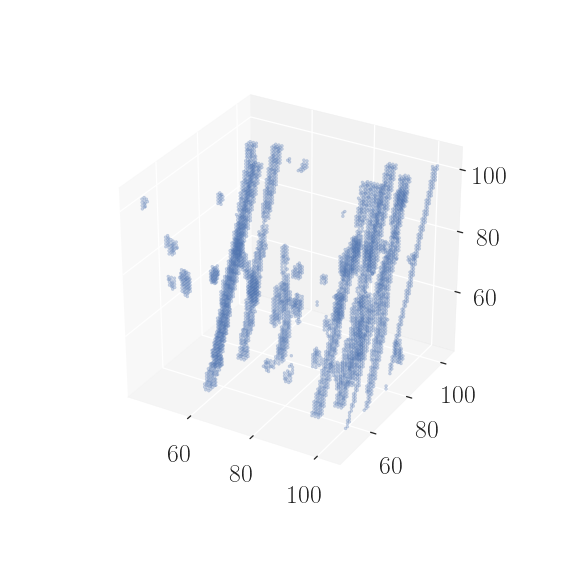

<IPython.core.display.Javascript object>


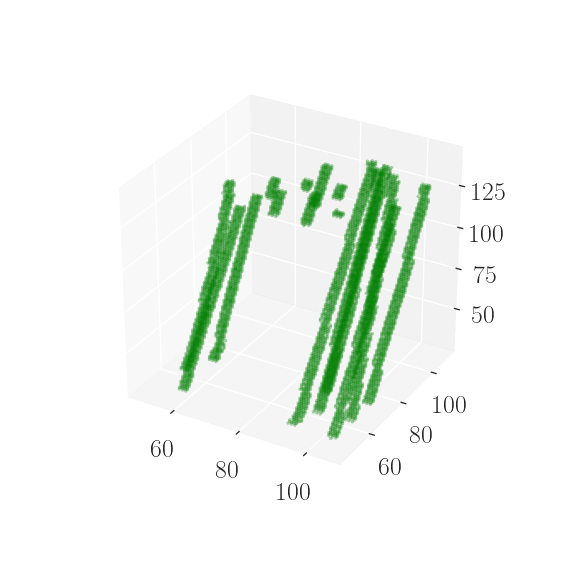

In [41]:
%matplotlib notebook
xs,ys,zs = np.where(prediction == 1)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs+44, ys+44, zs+44, marker='o', alpha=0.3, s=5)
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = np.where(label_data[i, ...,0] == 1)
ax.scatter(xs, ys, zs, marker='o',color='g', alpha=0.3, s=5)
plt.show()

In [42]:
from skimage import measure
from skimage import filters

<IPython.core.display.Javascript object>


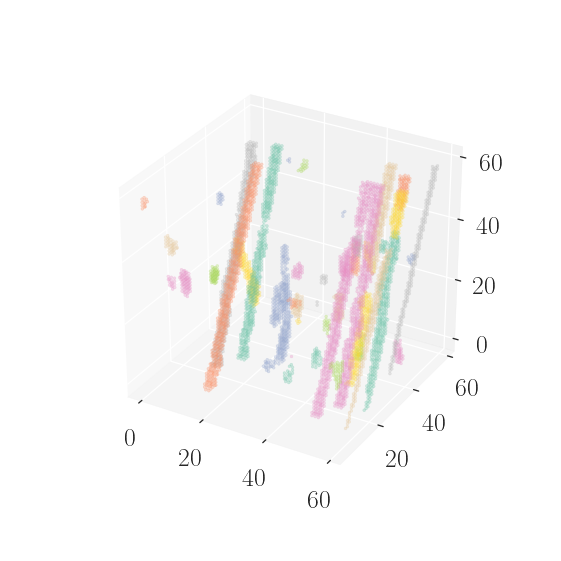

In [43]:
np.random.seed(1)
islands = measure.label(prediction)
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.3, s=5)
plt.show()

<IPython.core.display.Javascript object>


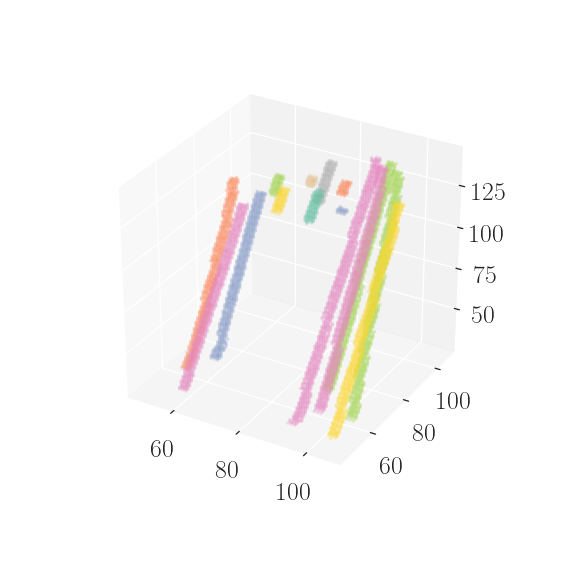

In [44]:
np.random.seed(1)
islands = measure.label(label_data[i,...,0])
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.3, s=5)
plt.show()

In [23]:
np.alltrue(blobs_labels==all_labels)

True

In [14]:
import pyximport; pyximport.install()
from fns.set_metrics import *

In [15]:
print(prediction.shape)
print(label_data[0,...,0].shape)
lab = crop_to_shape(label_data[...,0], prediction[np.newaxis,...].shape)
print(lab[0].shape)

(60, 60, 60)
(148, 148, 148)
(60, 60, 60)


In [16]:
labval = np.where(lab[0]!=False)
predval = np.where(prediction!=1)
# hausdorff_distance(np.array(labval),np.array(predval))
np.array(labval).shape
np.array(predval).shape

(3, 209990)

In [112]:
image_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/027/case.nrrd'
label_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/077/needles.nrrd'
img = provider._load_file(image_name, np.float32, padding="noise")
label = provider._load_file(label_name, np.bool, padding="zero")

data = provider._process_data(img)
label = provider._process_labels(label)

data, label = provider._post_process(data, label)

nx = data.shape[0]
ny = data.shape[1]
nz = data.shape[2]

data, label = data.reshape(1, nx, ny, nz, provider.channels), label.reshape(1, nx, ny, nz, provider.n_class)

In [113]:
data.shape

(1, 148, 148, 148, 1)

In [114]:
data.shape

(200, 200, 108)

In [115]:
tiles = (148,148,148)
tile = 148

In [138]:
data = nrrd.read(image_name)[0].astype(np.float32)
print(data.shape)
d = data.resize(max(data.shape[0],tile),
               max(data.shape[1],tile),
               max(data.shape[2],tile))
print(data.shape)



(200, 200, 108)
(200, 200, 148)


In [151]:
def getpad(size,block):
    if size%block:
        pad = block*(size//block+1) - size
    else:
        pad = 0
    return pad

def getpads(sizes, blocks):
    pads = []
    for i in range(3):
        print(sizes, blocks)
        pads.append([0,getpad(sizes[i], blocks[i])])
    return pads

def tiler(input, tile_shape):
    input = input[np.newaxis,...]
    ts = tile_shape
    input_shape = input.get_shape().as_list()
    print(input_shape)
    paddings = getpads(input_shape[:], tile_shape)
    batch = tf.space_to_batch_nd(input, tile_shape, paddings, name=None)
    batch = tf.transpose(batch, [3,1,2,0,4])
    batch = tf.reshape(batch, (-1, ts[0], ts[1], ts[2], input_shape[-1]))
    return batch


def reshapeData(batch_x, batch_y, tile_shape=(148,148,148), keepNoNeedle=True, start=0, data_provider=ImageDataProvider()):
    logits, labels = [], []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # initialize the graph
        batch_x = tf.Variable(batch_x)
        batch_y = tf.Variable(batch_y)
        tf.global_variables_initializer().run()

        resx = tiler(batch_x, tile_shape).eval()
        resy = tiler(batch_y, tile_shape).eval()
        if keepNoNeedle or np.max(resy)!=0:
            logits.append(resx)
            labels.append(resy)
    logits = np.array(logits)
    labels = np.array(labels)
    return np.concatenate(logits, axis=0), np.concatenate(labels, axis=0)

def reshapeDataset(nbOfCases, tile_shape=(100,100,100), keepNoNeedle=False, start=0, data_provider=ImageDataProvider()):
    logits, labels = [], []
    tf.reset_default_graph()
    with tf.Session() as sess:
        # initialize the graph
        for i in range(nbOfCases):
            batch_x, batch_y = data_provider(1)
            batch_x = tf.Variable(batch_x)
            batch_y = tf.Variable(batch_y)
            tf.global_variables_initializer().run()

            resx = tiler(batch_x, (100,100,100)).eval()
            resy = tiler(batch_y, (100,100,100)).eval()
            if keepNoNeedle or np.max(resy)!=0:
                logits.append(resx)
                labels.append(resy)
    logits = np.array(logits)
    labels = np.array(labels)
    return np.concatenate(logits, axis=0), np.concatenate(labels, axis=0)

Number of training data used: 37
Number of validation data used: 7
Number of testing data used: 3
Number of training data used: 37
Number of validation data used: 7
Number of testing data used: 3


In [153]:
data.shape

(200, 200, 148)

In [154]:
np.reshape(data,(-1,148,148,148))

ValueError: cannot reshape array of size 5920000 into shape (148,148,148)

In [160]:
Mx, My, Mz = data.shape
kx = Mx//tile + 1*((Mx%tile)>0)
ky = Mx//tile + 1*((My%tile)>0)
kz = Mz//tile + 1*((Mz%tile)>0)
print(Mx,My,Mz)
print(kx,ky,kz)

200 200 148
2 2 1


In [170]:
off_x = (kx*tile - Mx)/max(1,(kx-1))
off_y = ky*tile - My/max(1,(ky-1))
off_z = kz*tile - Mz/max(1,(kz-1))

arr_data = []
for i in range(kx):
    for j in range(ky):
        for k in range(kz):
            x = tile*i - off_x*i
            y = tile*j - off_y*j
            z = tile*k - off_z*k
            x = np.int(x)
            y = np.int(y)
            z = np.int(z)
            print(x,y,z)
            arr_data.append(data[x : x + tile, y : y + tile, z : z + tile ])
arr_data = np.array(arr_data)            

0 0 0
0 52 0
52 0 0
52 52 0


In [169]:
kz

1